In [1]:
import numpy as np
import scipy
import pandas as pd
import soundfile as sf
import librosa
import os
import matplotlib.pyplot as plt

In [2]:
def lpc_to_lsf(all_lpc):
    if len(all_lpc.shape) < 2:
        all_lpc = all_lpc[None]
    order = all_lpc.shape[1] - 1
    all_lsf = np.zeros((len(all_lpc), order))
    for i in range(len(all_lpc)):
        lpc = all_lpc[i]
        lpc1 = np.append(lpc, 0)
        lpc2 = lpc1[::-1]
        sum_filt = lpc1 + lpc2
        diff_filt = lpc1 - lpc2

        if order % 2 != 0:
            deconv_diff, _ = scipy.signal.deconvolve(diff_filt, [1, 0, -1])
            deconv_sum = sum_filt
        else:
            deconv_diff, _ = scipy.signal.deconvolve(diff_filt, [1, -1])
            deconv_sum, _ = scipy.signal.deconvolve(sum_filt, [1, 1])

        roots_diff = np.roots(deconv_diff)
        roots_sum = np.roots(deconv_sum)
        angle_diff = np.angle(roots_diff)
        angle_sum = np.angle(roots_sum)
        angle_diff = angle_diff[np.where(angle_diff > 0)]
        angle_sum = angle_sum[np.where(angle_sum > 0)]
        lsf = np.sort(np.hstack((angle_diff, angle_sum)))
        if len(lsf) != 0:
            all_lsf[i] = lsf
    return np.squeeze(all_lsf)

/tmp/ipykernel_3188041/3378581565.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,5))


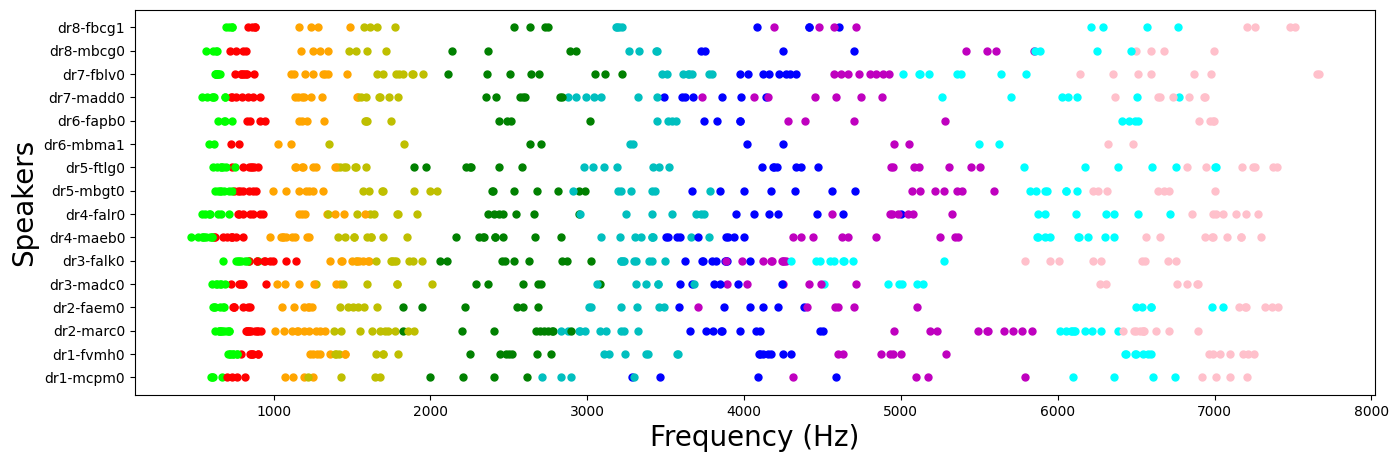

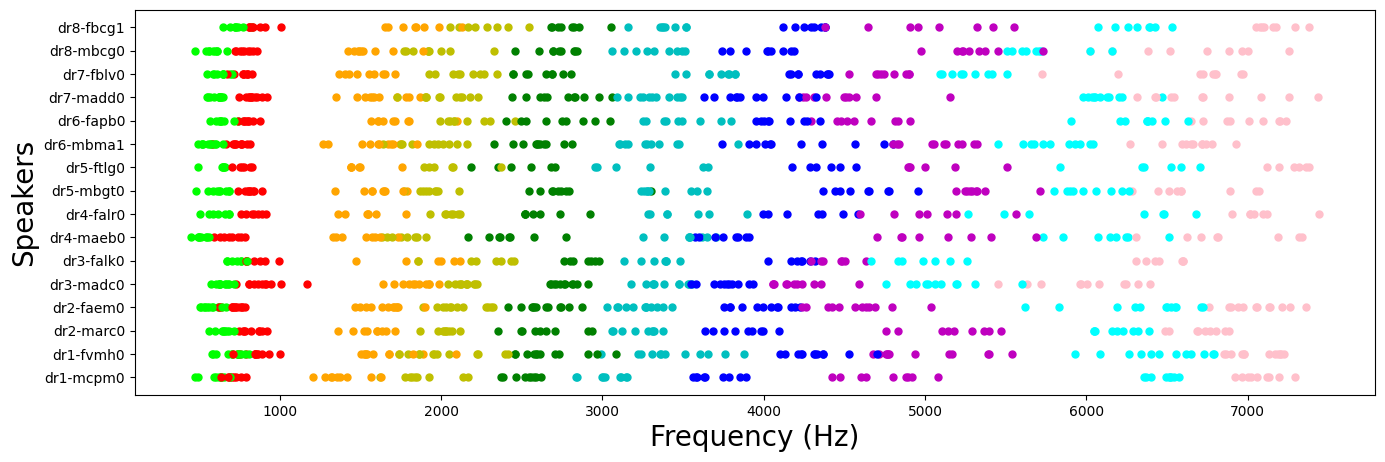

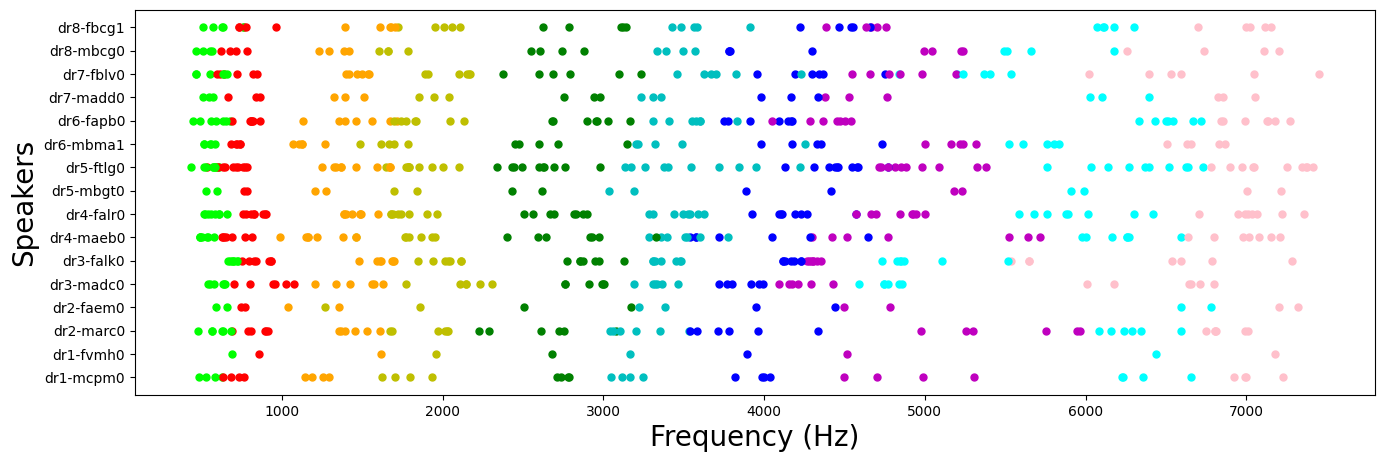

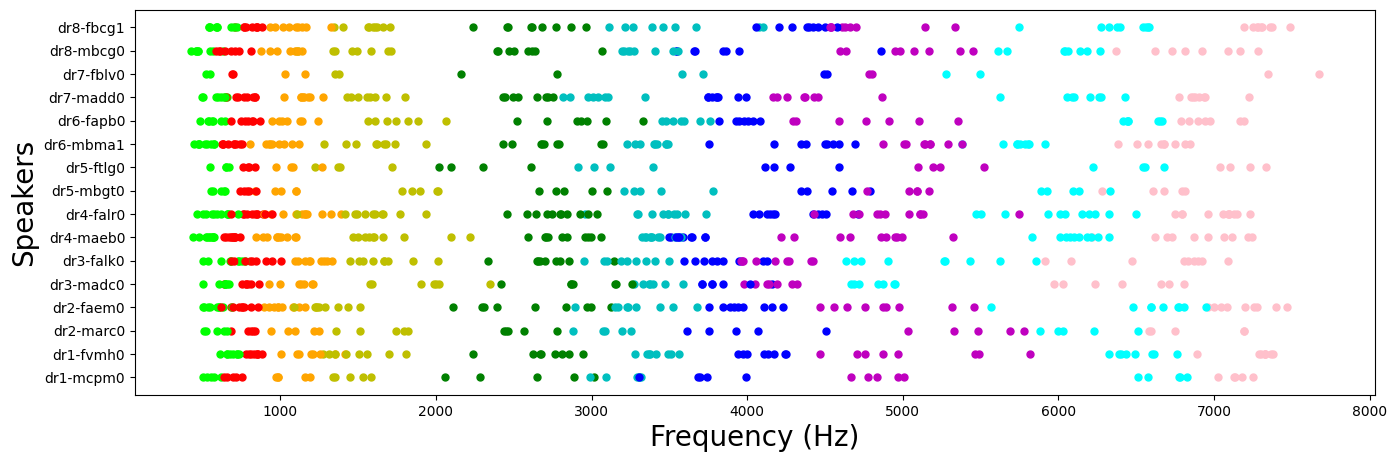

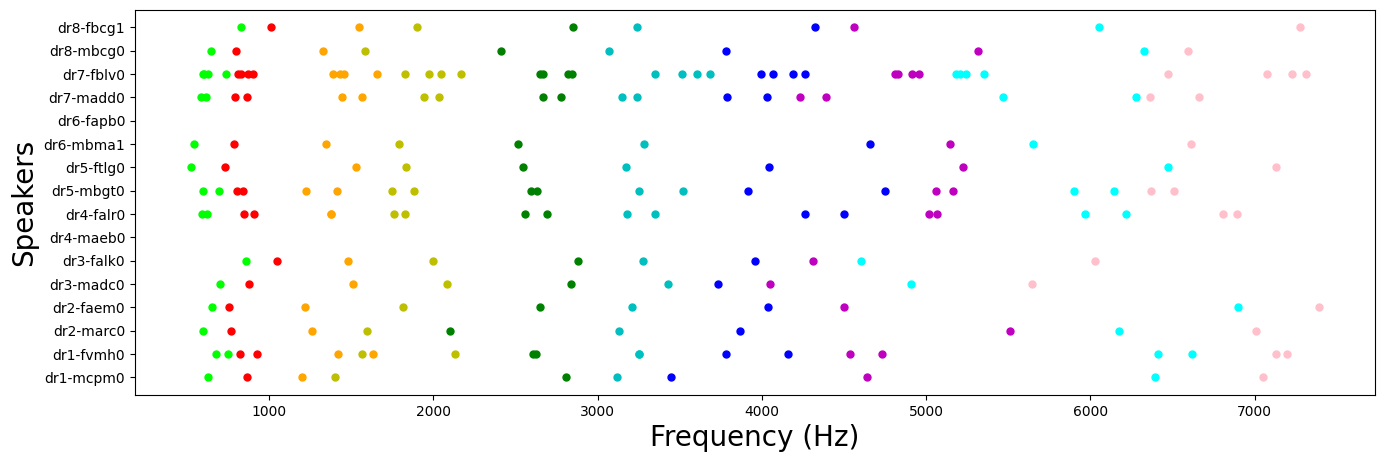

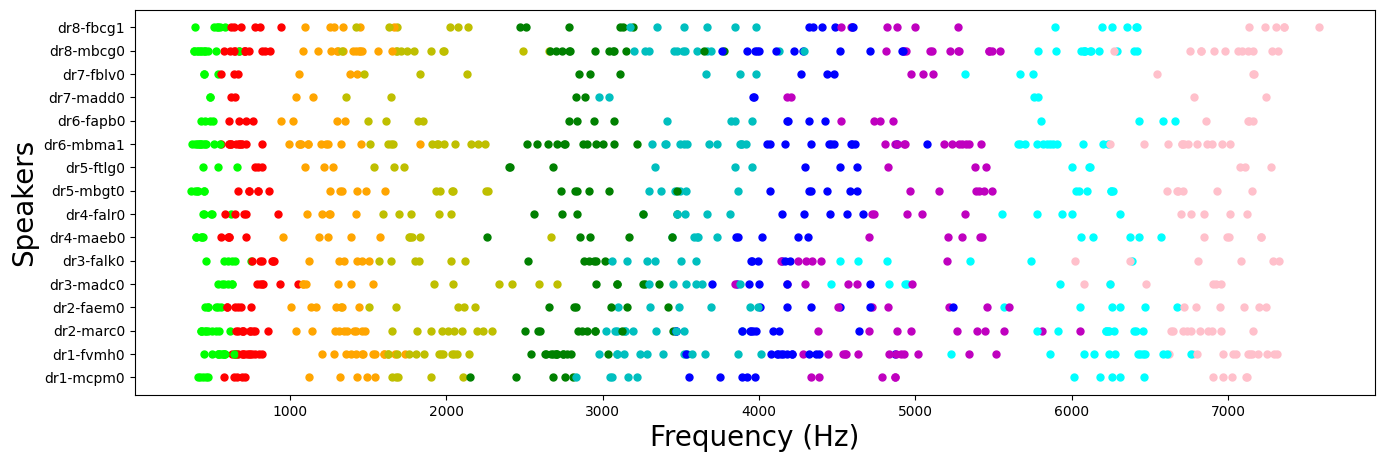

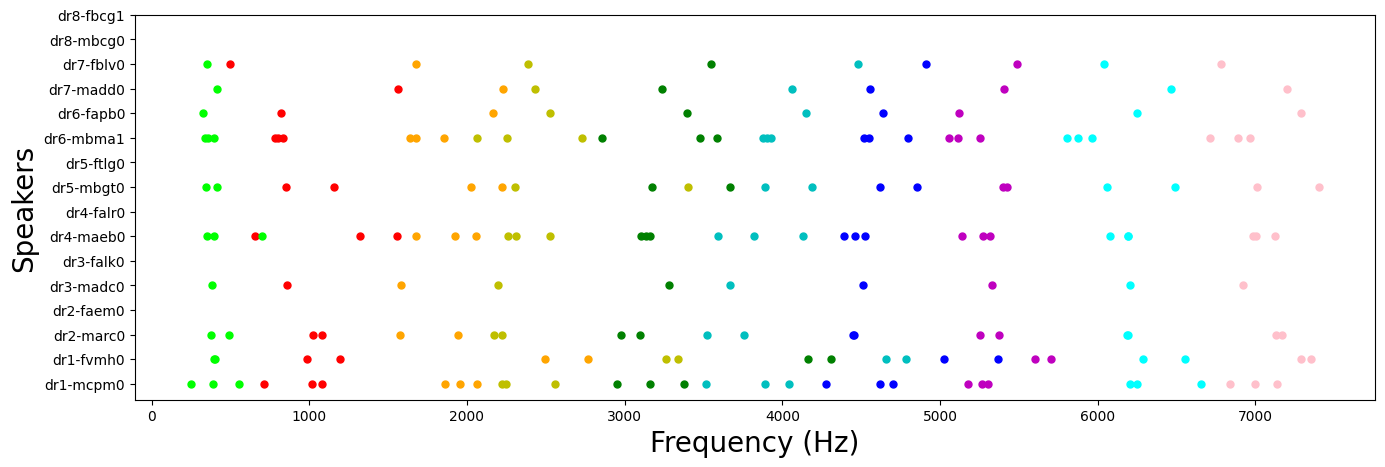

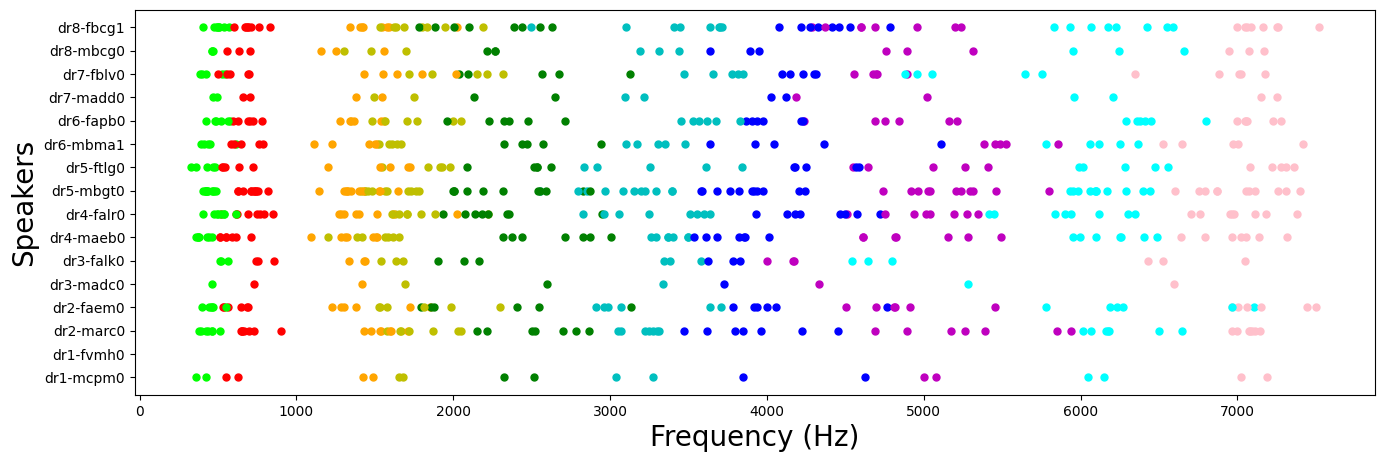

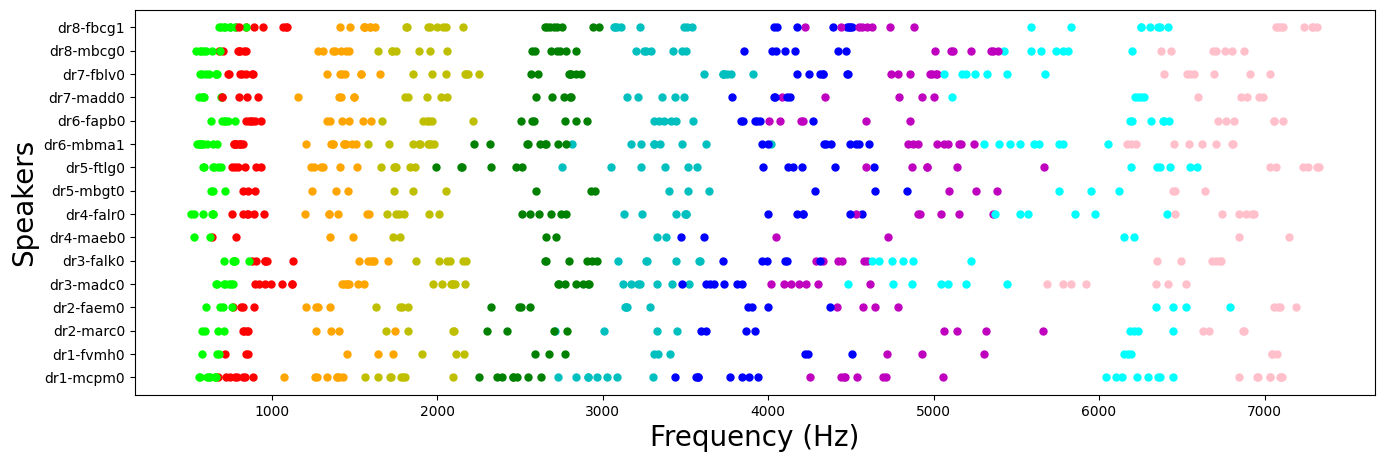

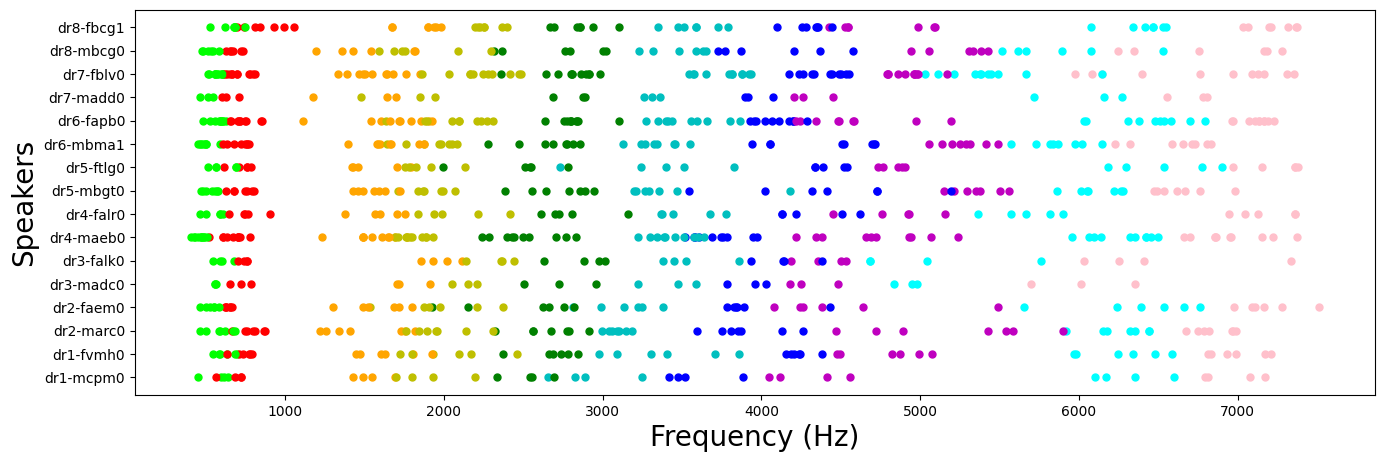

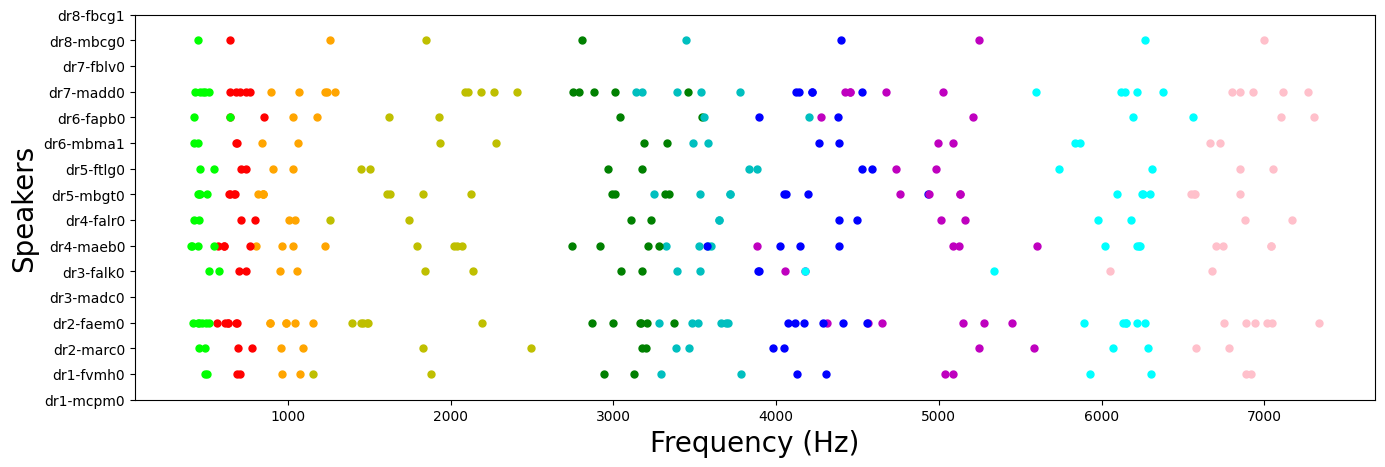

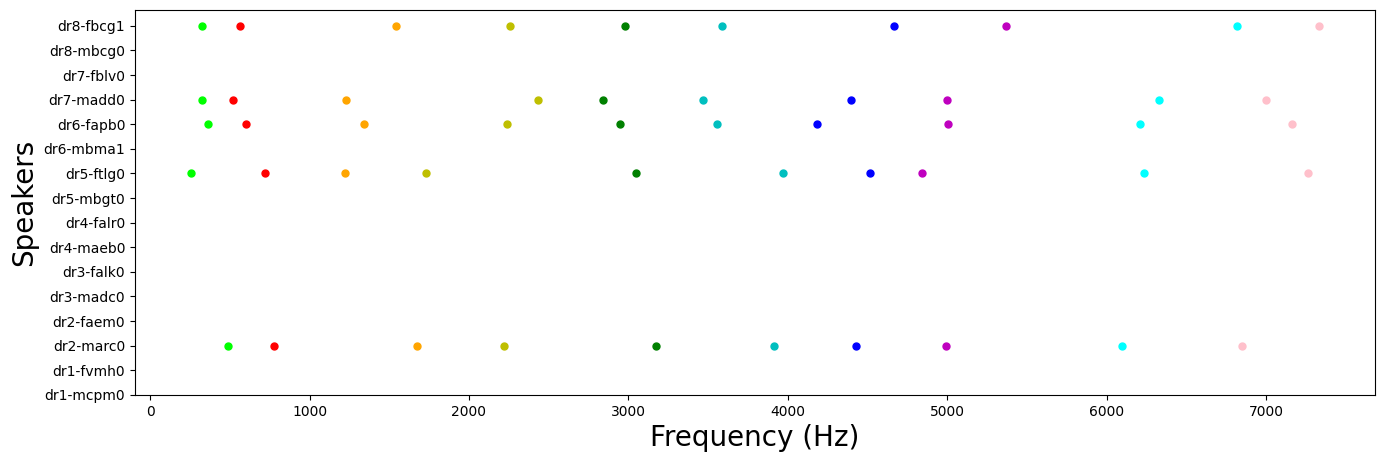

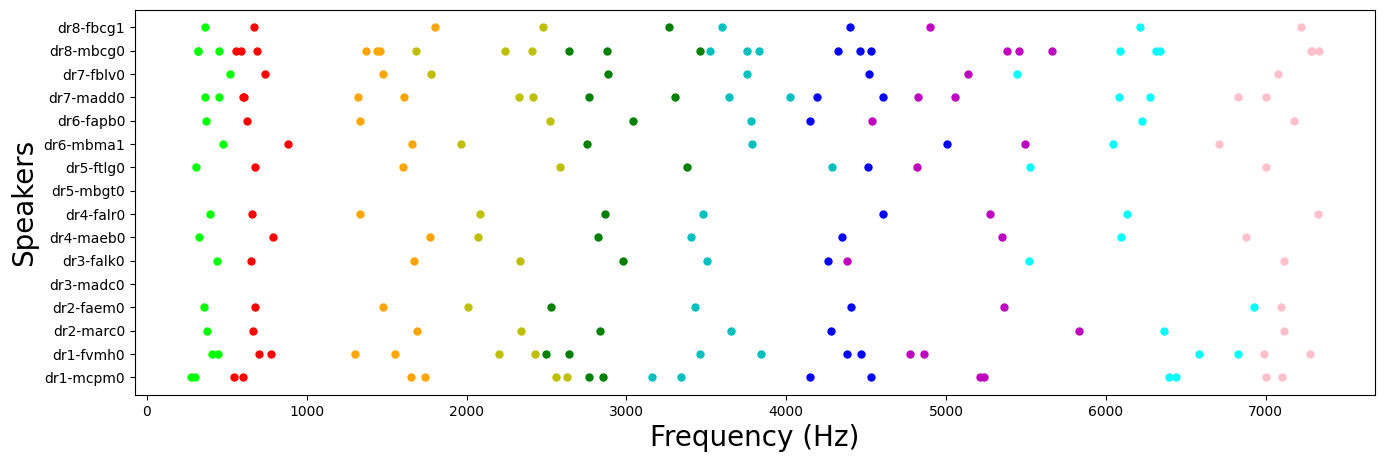

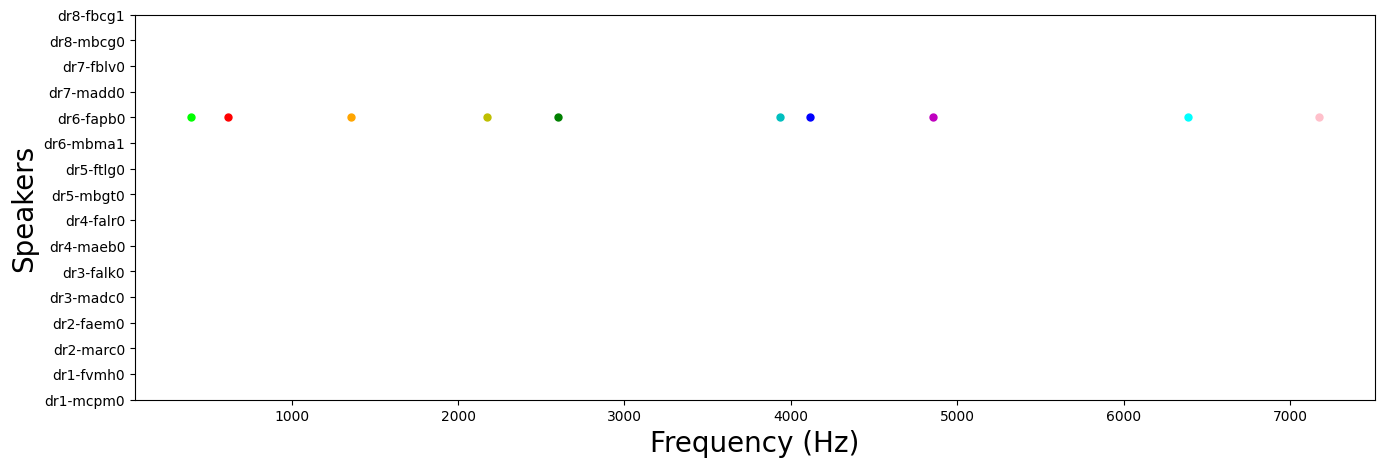

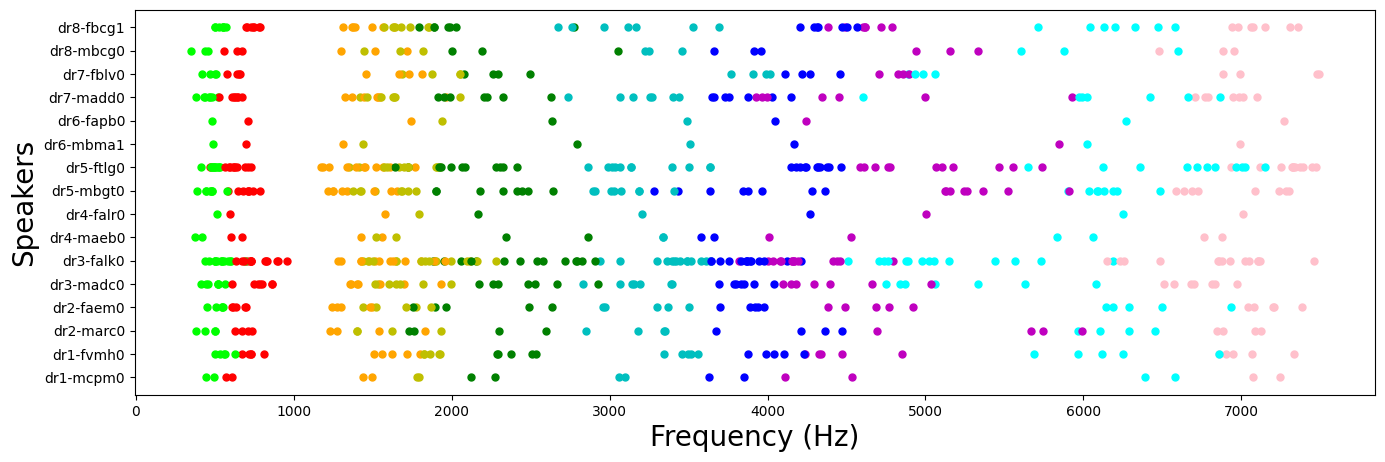

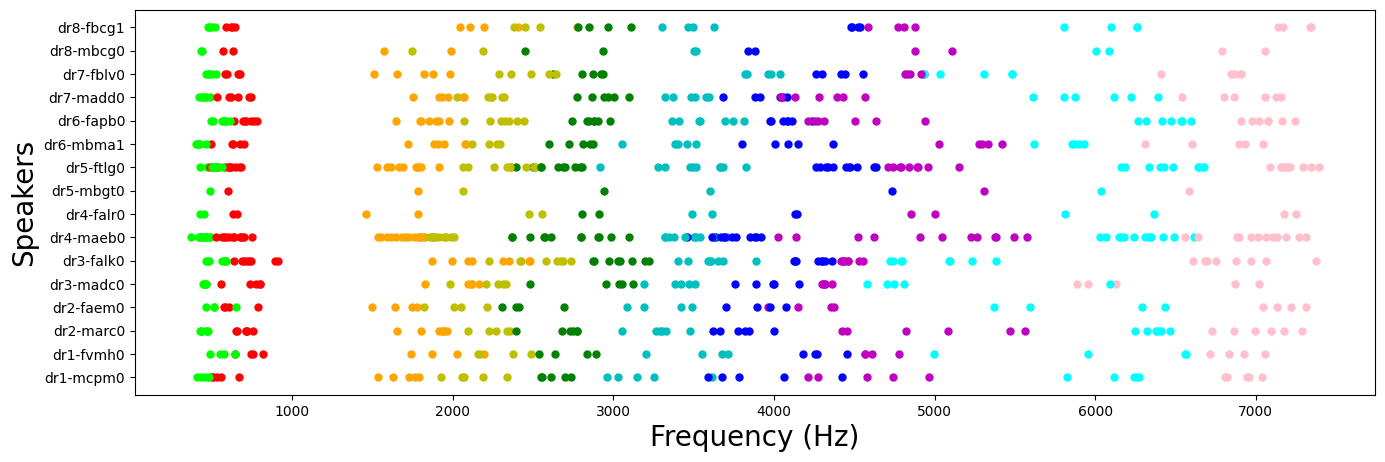

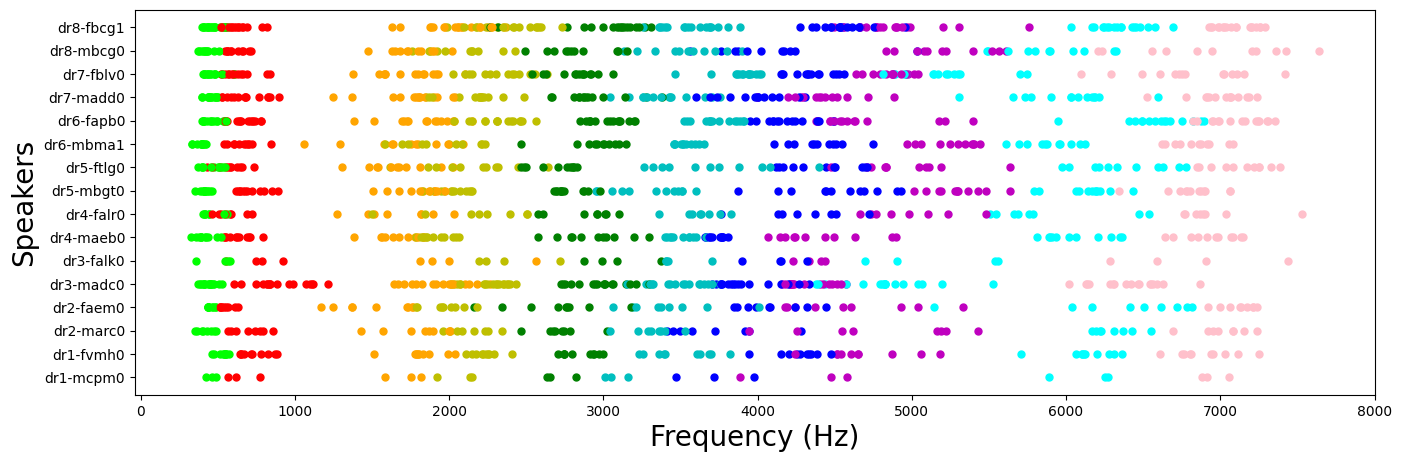

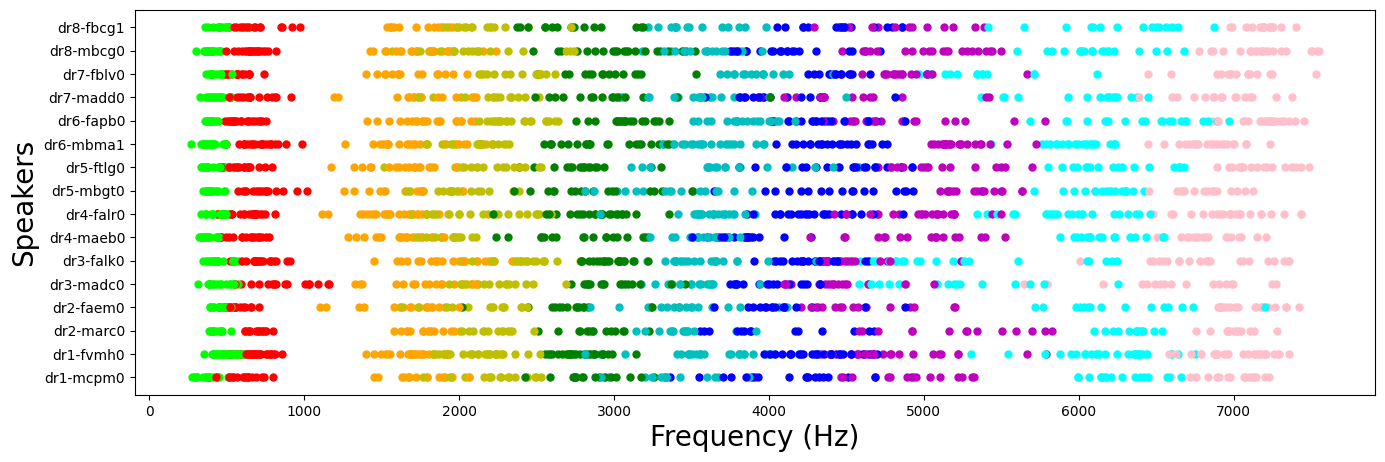

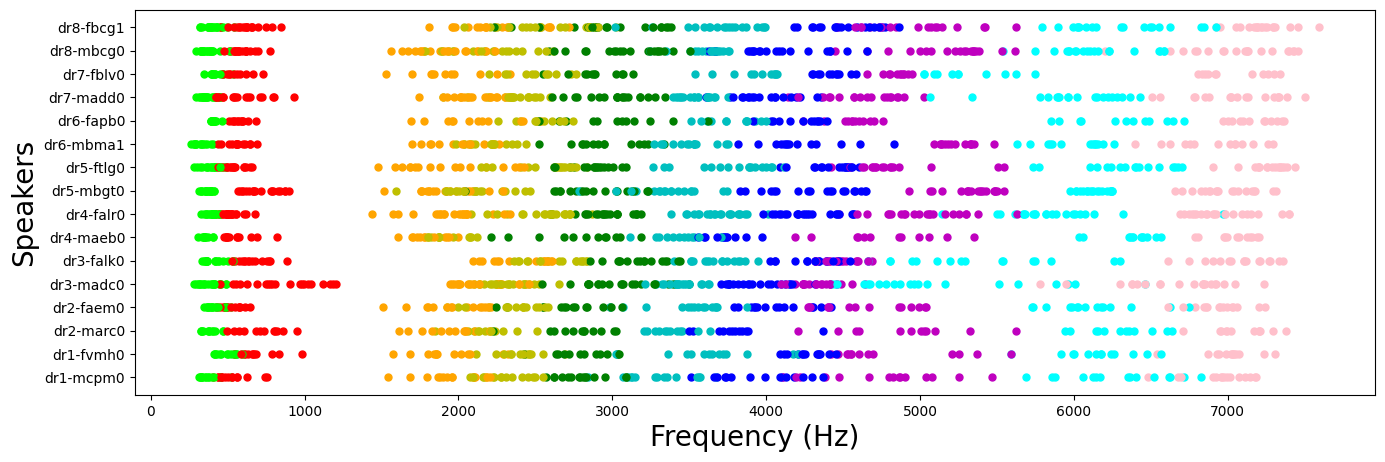

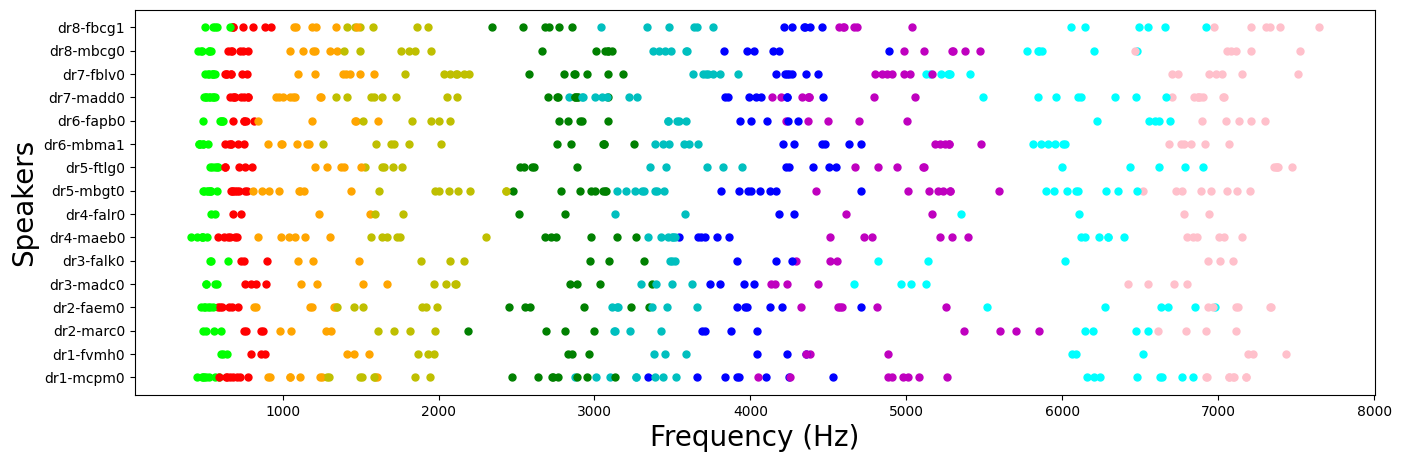

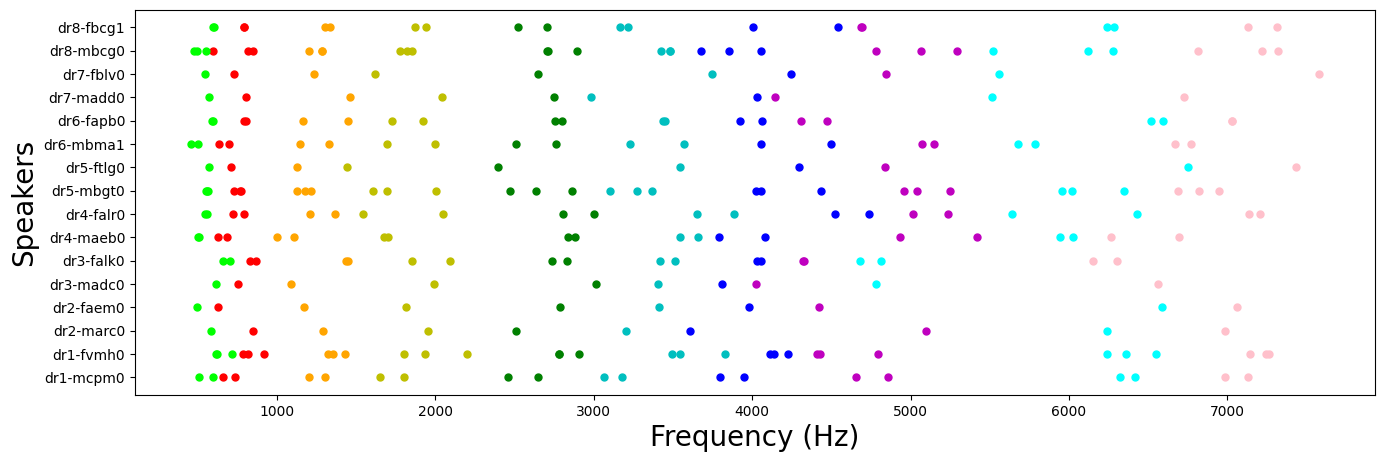

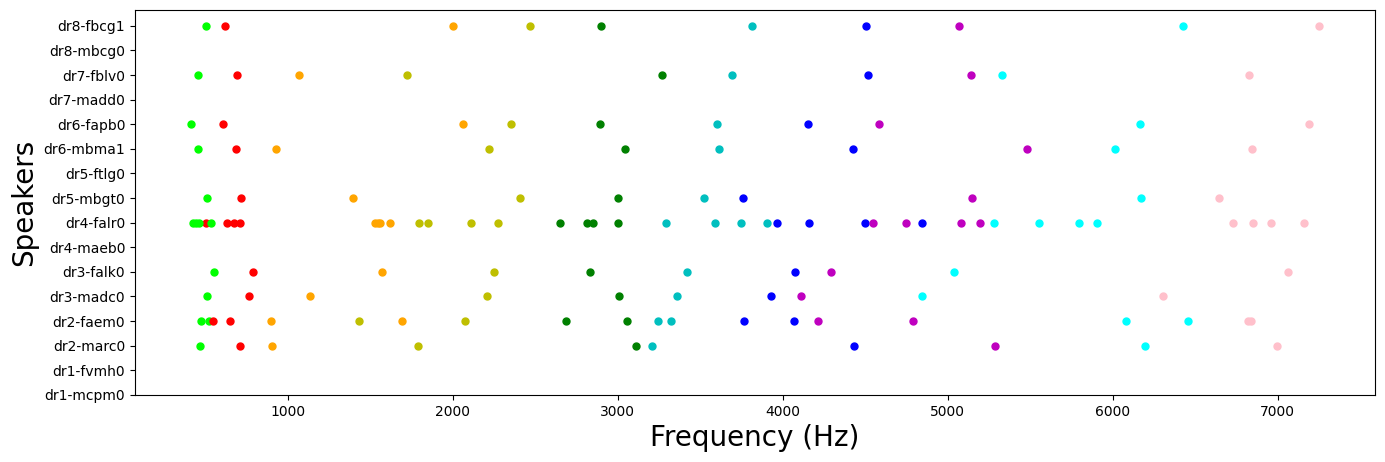

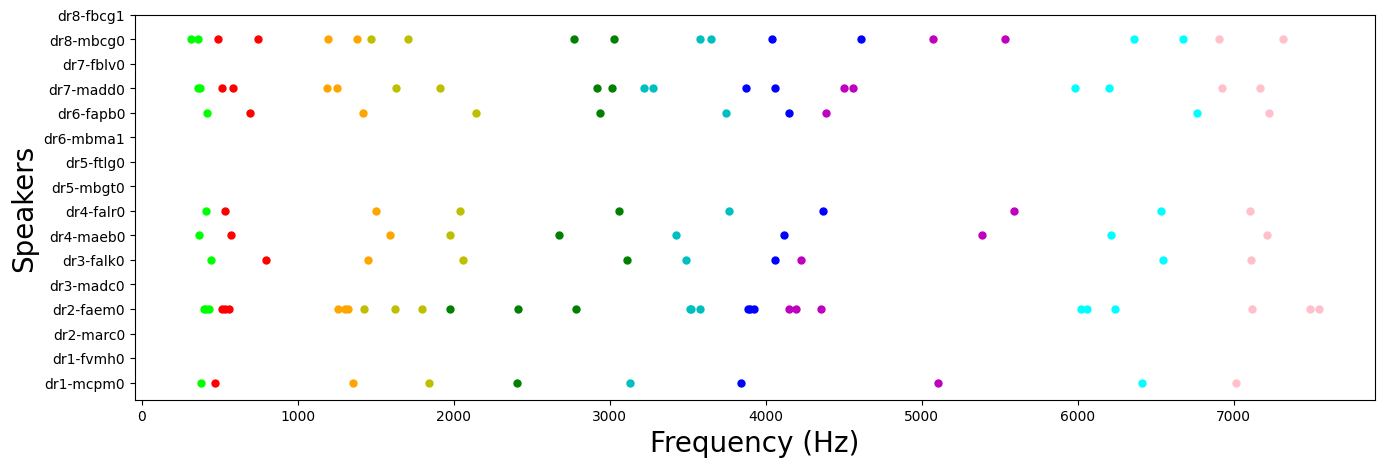

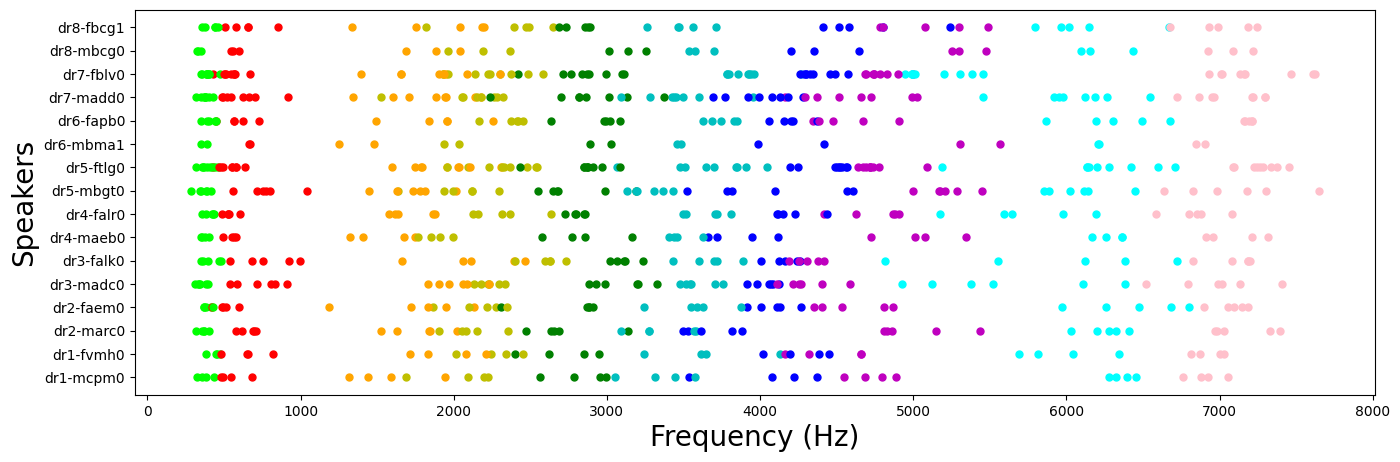

In [9]:
df_allfilelist = pd.read_table('/mnt/lxc/TIMIT Core Test Set/timit/allfilelist.txt')
file_names = df_allfilelist.values

lpc_order = 10
vowels = ['aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'ax-h', 'axr', 'ay', 'eh', 'el', 'em', 'en', 'eng', 'er', 'ey', 'ih', 'ix', 'iy', 'ow', 'oy', 'uh', 'uw', 'ux']

for vowel in vowels:
    speakers = []
    plt.figure(figsize=(16,5))
    for file_name in file_names:
        file_name = file_name[0]
        if file_name.split('/')[0] not in speakers:
            speakers.append(file_name.split('/')[0])
        os.makedirs('./TIMIT/lpc/'+file_name.split('/')[0], exist_ok=True)
        os.makedirs('./TIMIT/lsf/'+file_name.split('/')[0], exist_ok=True)
        orig_data, sr = sf.read('/mnt/lxc/TIMIT Core Test Set/timit/' + file_name + '.wav')
        f = open('/mnt/lxc/TIMIT Core Test Set/timit/' + file_name + '.phn', 'r')
        lines = f.readlines()
        f.close()   
        f_lsf = open('./TIMIT/lsf/'+file_name+'.txt', 'w')
        f_lpc = open('./TIMIT/lpc/'+file_name+'.txt', 'w')
        for line in lines:
            start = line.split()[0]
            end = line.split()[1]
            if line.split()[2] == vowel:
                # 截取音频片段
                y_origin = orig_data[int(start):int(end)]
                lpc_coefficients = librosa.lpc(y_origin, order = lpc_order)
                lsf_coefficients = lpc_to_lsf(lpc_coefficients)
                # plt.plot(lsf_coefficients/np.pi*sr/2,np.repeat(0.01*(len(speakers)-1)+vowels.index(line.split()[2]),10),'o',markersize=5)
                plt.plot(lsf_coefficients[0]/np.pi*sr/2,0.01*(len(speakers)-1),'o',markersize=5,color='lime')
                plt.plot(lsf_coefficients[1]/np.pi*sr/2,0.01*(len(speakers)-1),'o',markersize=5,color='r')
                plt.plot(lsf_coefficients[2]/np.pi*sr/2,0.01*(len(speakers)-1),'o',markersize=5,color='orange')
                plt.plot(lsf_coefficients[3]/np.pi*sr/2,0.01*(len(speakers)-1),'o',markersize=5,color='y')
                plt.plot(lsf_coefficients[4]/np.pi*sr/2,0.01*(len(speakers)-1),'o',markersize=5,color='g')
                plt.plot(lsf_coefficients[5]/np.pi*sr/2,0.01*(len(speakers)-1),'o',markersize=5,color='c')
                plt.plot(lsf_coefficients[6]/np.pi*sr/2,0.01*(len(speakers)-1),'o',markersize=5,color='b')
                plt.plot(lsf_coefficients[7]/np.pi*sr/2,0.01*(len(speakers)-1),'o',markersize=5,color='m')
                plt.plot(lsf_coefficients[8]/np.pi*sr/2,0.01*(len(speakers)-1),'o',markersize=5,color='cyan')
                plt.plot(lsf_coefficients[9]/np.pi*sr/2,0.01*(len(speakers)-1),'o',markersize=5,color='pink')
                f_lpc.write(start+' '+end+' '+line.split()[2]+' '+str(lpc_coefficients) + '\n')
                f_lsf.write(start+' '+end+' '+line.split()[2]+' '+str(lsf_coefficients) + '\n')
    plt.xlabel('Frequency (Hz)', fontsize=20)
    plt.ylabel('Speakers', fontsize=20)
    plt.yticks(0.01*np.arange(0, len(speakers)),speakers)
    plt.savefig(f'./fig/different_people_lsf_{vowel}.png')